## Bile acid analysis

In [1]:
import pandas as pd
import qiime2 as q2
import biom
from biom import load_table, Table
from biom.util import biom_open
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests
from math import log
%matplotlib inline

In [3]:
!ls

10781_20190528-121437.txt           Kumar_BIOM_normalized_cpm_qa1.tsv
GNPS                                Kumar_Metabolomics_Prepfile.txt
Kumar_BIOM_normalized.biom          beta_ja18
Kumar_BIOM_normalized_cpm.biom      beta_qa1
Kumar_BIOM_normalized_cpm.qza       bile acid.ipynb
Kumar_BIOM_normalized_cpm_ja18.biom metabolite_metadata.tsv
Kumar_BIOM_normalized_cpm_ja18.qza  nash_metabolomics_pipeline.md
Kumar_BIOM_normalized_cpm_qa1.biom  qa1_cpm_transposed.txt
Kumar_BIOM_normalized_cpm_qa1.qza   songbird


# Import data

In [2]:
md = pd.read_csv("10781_20190528-121437.txt", sep='\t', index_col=0)
bile_acid_md = pd.read_csv("bile_acid_md.txt", sep='\t', index_col=0)

#Data (import biom because it has metabolite metadata)
bt = load_table("Kumar_BIOM_normalized_cpm.biom")

#Extract metabolite metadata
met_md = bt.metadata_to_dataframe(axis="observation")

In [3]:
#Export met metadata for excel viewing
met_md.to_csv("met_metadata.tsv", sep='\t')

In [4]:
#Extract just bile acids
bile_acid_ids = set(bile_acid_md.index)
bt.filter(ids_to_keep=bile_acid_ids, axis="observation")

48 x 274 <class 'biom.table.Table'> with 7576 nonzero entries (57% dense)

# Sum by bile acid

In [5]:
bile_acid_dict = {row.name:{"bile_acid":row.bile_acid} for i,row in bile_acid_md.iterrows()}
#Add bile acid metadata
bt.add_metadata(md=bile_acid_dict, axis="observation")

In [6]:
#Collapse table by bile acid
bin_f = lambda id_, x: x["bile_acid"]
bt_collapse = bt.collapse(f= bin_f, norm=False, axis="observation")

df_collapse = pd.DataFrame(bt_collapse.to_dataframe())

/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)


# Analyze collapsed values

In [7]:
bile_acid_type_df = pd.DataFrame(bile_acid_md.loc[:,["type_of_bile_acid", "bile_acid"]]).reset_index().drop(columns="id").groupby("bile_acid").first().reset_index()

df_collapse_melt = df_collapse.reset_index().melt(id_vars="index")
df_collapse_melt.columns = ["bile_acid","sample","value"]
#Add bile acid md
df_collapse_melt = df_collapse_melt.merge(bile_acid_type_df, left_on="bile_acid", right_on="bile_acid", how="left")
#Add sample md
df_collapse_melt = df_collapse_melt.merge(md, left_on="sample", right_on="sample_name")
df_collapse_melt = df_collapse_melt.replace("taurohyocholic acid","Taurohyocholic acid")

# Matplot lib plot

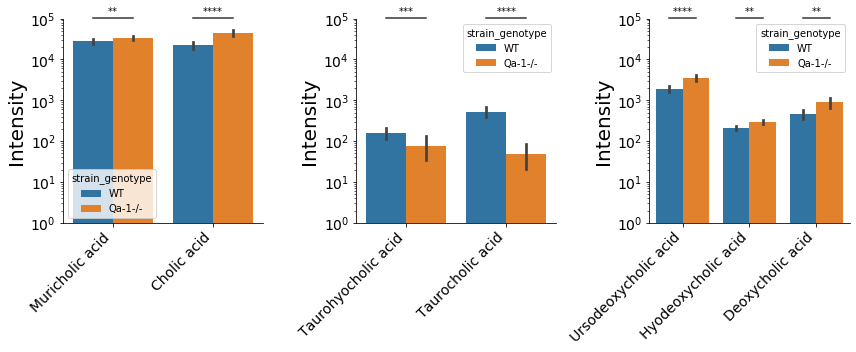

In [11]:
plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()
sig_dict = {"Ursodeoxycholic acid":7.473e-06,
'Hyodeoxycholic acid':3.201e-03,
"Muricholic acid":3.109e-02,
 "Cholic acid":3.883e-07,
 "Deoxycholic acid":5.302e-03,
 "taurohyocholic acid":1.139e-03,
 "Taurocholic acid":8.290e-06
}

fig,axs =  plt.subplots(1,3, figsize=(12,5))
#fig.figure()
for n, ba_type in enumerate(["primary","primary conjugated","secondary"]):
    subplot_dat = plot_dat.query('type_of_bile_acid==@ba_type')
    
    axs[n].set( yscale="log")
    sns.barplot(data=subplot_dat, hue="strain_genotype", y="value", x="bile_acid",linewidth=3, ax=axs[n])
    #sns.swarmplot( data=subplot_dat, x="strain_genotype", y="value", color="black", ax=axs[n])
    axs[n].set_ylim(1,100000)
    for i,box in enumerate(axs[n].artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

        for j in range(6*i,6*(i+1)):
             axs[n].lines[j].set_color('black')

    axs[n].spines['right'].set_visible(False)
    axs[n].spines['top'].set_visible(False)
    
    bile_acids = set(subplot_dat.bile_acid)
    box_pairs=[((x,"WT"),(x,"Qa-1-/-")) for x in bile_acids]
    
    add_stat_annotation(axs[n], data=subplot_dat, x="bile_acid", y="value", hue="strain_genotype",
                        box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='star', loc='outside',verbose=0)
    
    axs[n].set_xlabel('')
    axs[n].set_ylabel('Intensity', fontsize=20)
    axs[n].tick_params(axis = 'both', which = 'major', labelsize = 14)
    for label in axs[n].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
        
plt.tight_layout()
#fig.savefig("sig_faith_pd.png")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Cholic acid_WT v.s. Cholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.883e-07 U_stat=1.626e+03
Deoxycholic acid_WT v.s. Deoxycholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.302e-03 U_stat=2.256e+03
Taurocholic acid_WT v.s. Taurocholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.290e-06 U_stat=4.627e+03
Taurohyocholic acid_WT v.s. Taurohyocholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.139e-03 U_stat=4.333e+03
Ursodeoxycholic acid_WT v.s. Ursodeoxycholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.473e-06 U_stat=1.793e+03
Hyodeoxycholic acid_WT v.s. Hyodeoxycholic acid_Qa-1-/-: Mann-Whitney-Wilcoxon test two

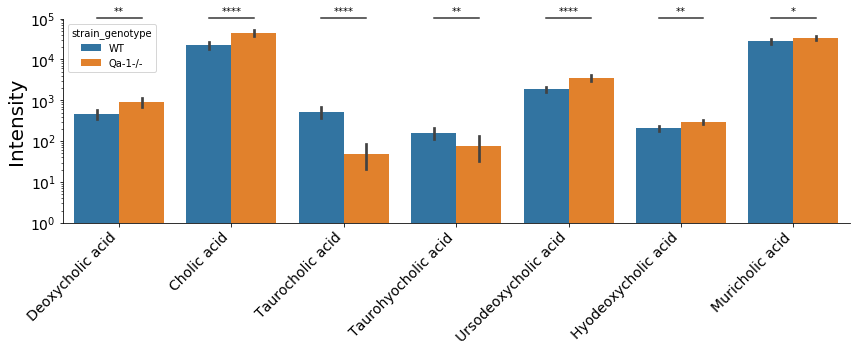

In [12]:
plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()


fig,axs =  plt.subplots(1,1, figsize=(12,5))
#fig.figure()

subplot_dat = plot_dat.query('type_of_bile_acid==@ba_type')
ba_ord = list(set(plot_dat.bile_acid))
axs.set( yscale="log")
sns.barplot(data=plot_dat, hue="strain_genotype", y="value", x="bile_acid",linewidth=3, ax=axs, order = ba_ord)
#sns.swarmplot( data=plot_dat, hue="strain_genotype", y="value", x="bile_acid", ax=axs)
axs.set_ylim(1,100000)
for i,box in enumerate(axs.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    for j in range(6*i,6*(i+1)):
         axs.lines[j].set_color('black')

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)


bile_acids = set(plot_dat.bile_acid)
box_pairs=[((x,"WT"),(x,"Qa-1-/-")) for x in ba_ord]

add_stat_annotation(axs, data=plot_dat, x="bile_acid", y="value", hue="strain_genotype",
                    box_pairs=box_pairs,order = ba_ord,
                    test='Mann-Whitney', text_format='star', loc='outside',verbose=2)

axs.set_xlabel('')
axs.set_ylabel('Intensity', fontsize=20)
axs.tick_params(axis = 'both', which = 'major', labelsize = 14)
for label in axs.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
        
plt.tight_layout()
#fig.savefig("sig_faith_pd.png")

In [30]:
{bile_acid:pval for bile_acid,pval in zip(sig_dict.keys(),corrected_pvalues)}

{'Ursodeoxycholic acid': 5.2311e-05,
 'Hyodeoxycholic acid': 0.022407,
 'Muricholic acid': 0.21763,
 'Cholic acid': 2.7181e-06,
 'Deoxycholic acid': 0.037114,
 'Taurohyocholic acid': 0.007973000000000001,
 'Taurocholic acid': 5.803e-05}

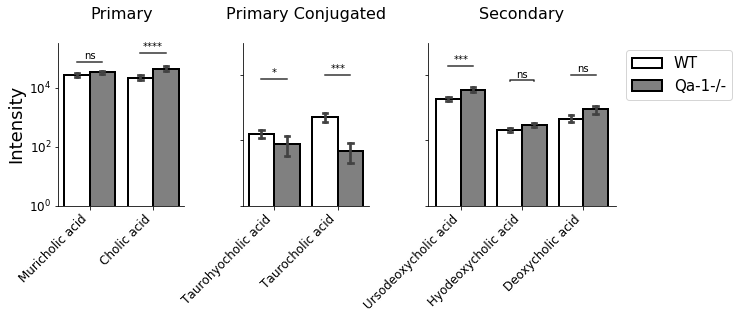

In [11]:
plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()
sig_dict = {"Ursodeoxycholic acid":7.473e-06,
'Hyodeoxycholic acid':3.201e-03,
"Muricholic acid":3.109e-02,
 "Cholic acid":3.883e-07,
 "Deoxycholic acid":5.302e-03,
 "Taurohyocholic acid":1.139e-03,
 "Taurocholic acid":8.290e-06
}
corrected_pvalues = multipletests(pvals=list(sig_dict.values()), method="bonferroni")[1]
sig_dict_corrected = {bile_acid:pval for bile_acid,pval in zip(sig_dict.keys(),corrected_pvalues)}

fig,axs =  plt.subplots(1,3, figsize=(10,3),gridspec_kw={'width_ratios': [1, 1,1.5]})
fig.subplots_adjust(wspace=0.4)
#fig.figure()
for n, ba_type in enumerate(["primary","primary conjugated","secondary"]):
    cap_d = {"primary":"Primary\n","primary conjugated":"Primary Conjugated\n","secondary":"Secondary\n"}
    axs[n].set_title(cap_d[ba_type], fontsize=16)
    subplot_dat = plot_dat.query('type_of_bile_acid==@ba_type')
    
    axs[n].set( yscale="log")
    sns.barplot(data=subplot_dat, hue="strain_genotype", y="value", x="bile_acid",
                linewidth=2, ax=axs[n], capsize=.07, palette=["white","grey"], edgecolor="black")
    #sns.swarmplot( data=subplot_dat, x="strain_genotype", y="value", color="black", ax=axs[n])
    axs[n].set_ylim(1,100000)
    for i,box in enumerate(axs[n].artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')

        for j in range(6*i,6*(i+1)):
             axs[n].lines[j].set_color('black')

    axs[n].spines['right'].set_visible(False)
    axs[n].spines['top'].set_visible(False)
    
    bile_acids = set(subplot_dat.bile_acid)
    box_pairs=[((x,"WT"),(x,"Qa-1-/-")) for x in bile_acids]
    
    add_stat_annotation(axs[n], data=subplot_dat, x="bile_acid", y="value", hue="strain_genotype",
                        pvalues=[sig_dict_corrected[ba] for ba in bile_acids], perform_stat_test=False, 
                        test=None, box_pairs=box_pairs, line_height=.001,
                        text_format='star', loc='inside',verbose=0,
                       pvalue_thresholds=[[.00001, "****"], [.0001, "***"], [.001, "**"], [0.01, "*"], [1, "ns"]])
    
    axs[n].set_xlabel('')
    axs[n].set_ylabel('Intensity', fontsize=18)
    axs[n].tick_params(axis = 'both', which = 'major', labelsize = 12)
    for label in axs[n].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    axs[n].get_legend().remove()
    #Hide y axis values for plots 2 and 3
    if n!=0:
        axs[n].set_yticklabels([])
        axs[n].set_ylabel('', fontsize=0)
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 15})
        
#plt.tight_layout()
#fig.savefig("sig_faith_pd.png")

In [16]:
?pd.Categorical

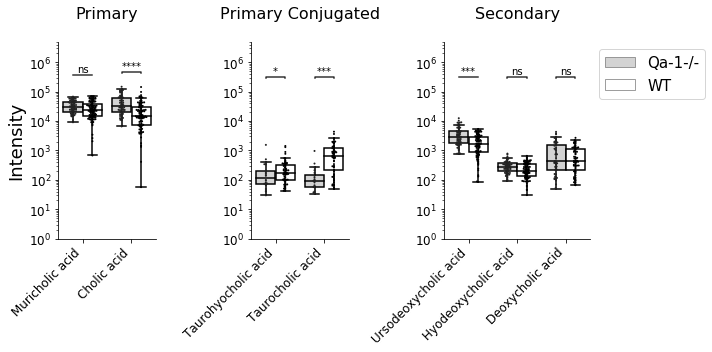

In [52]:
plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()
plot_dat["strain_genotype"] = pd.Categorical(plot_dat.strain_genotype, categories=["Qa-1-/-","WT"], ordered=True)
sig_dict = {"Ursodeoxycholic acid":7.473e-06,
'Hyodeoxycholic acid':3.201e-03,
"Muricholic acid":3.109e-02,
 "Cholic acid":3.883e-07,
 "Deoxycholic acid":5.302e-03,
 "Taurohyocholic acid":1.139e-03,
 "Taurocholic acid":8.290e-06
}

corrected_pvalues = multipletests(pvals=list(sig_dict.values()), method="bonferroni")[1]
sig_dict_corrected = {bile_acid:pval for bile_acid,pval in zip(sig_dict.keys(),corrected_pvalues)}

fig,axs =  plt.subplots(1,3, figsize=(10,5),gridspec_kw={'width_ratios': [1, 1,1.5]})
fig.subplots_adjust(wspace=0.4)
#fig.figure()
for n, ba_type in enumerate(["primary","primary conjugated","secondary"]):
    cap_d = {"primary":"Primary\n","primary conjugated":"Primary Conjugated\n","secondary":"Secondary\n"}
    axs[n].set_title(cap_d[ba_type], fontsize=16)
    subplot_dat = plot_dat.query('type_of_bile_acid==@ba_type & value != 0')
    
    axs[n].set( yscale="log")
    
    sns.boxplot(data=subplot_dat, hue="strain_genotype", y="value", x="bile_acid",
                ax=axs[n], palette=["lightgrey", "white"], fliersize=0)
    sns.swarmplot( data=subplot_dat, hue="strain_genotype", y="value",  x="bile_acid",
                  color="black", ax=axs[n], size=2, dodge=True)
    axs[n].set_ylim(1,5000000)
    for i,box in enumerate(axs[n].artists):
        box.set_edgecolor('black')
        #box.set_facecolor('white')

        for j in range(6*i,6*(i+1)):
             axs[n].lines[j].set_color('black')

    axs[n].spines['right'].set_visible(False)
    axs[n].spines['top'].set_visible(False)
    
    bile_acids = set(subplot_dat.bile_acid)
    box_pairs=[((x,"WT"),(x,"Qa-1-/-")) for x in bile_acids]
    
    add_stat_annotation(axs[n], data=subplot_dat, x="bile_acid", y="value", hue="strain_genotype",
                        pvalues=[sig_dict_corrected[ba] for ba in bile_acids], perform_stat_test=False, 
                        test=None, box_pairs=box_pairs, line_height=.001,
                        text_format='star', loc='inside',verbose=0,
                       pvalue_thresholds=[[.00001, "****"], [.0001, "***"], [.001, "**"], [0.01, "*"], [1, "ns"]])
    
    axs[n].set_xlabel('')
    axs[n].set_ylabel('Intensity', fontsize=18)
    axs[n].tick_params(axis = 'both', which = 'major', labelsize = 12)
    for label in axs[n].get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    axs[n].get_legend().remove()
    #Hide y axis values for plots 2 and 3
    if n!=0:
        #axs[n].set_yticklabels([])
        axs[n].set_ylabel('', fontsize=0)

handles, labels =  plt.gca().get_legend_handles_labels()
lgd = plt.legend(handles[:2], labels[:2],bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 15})


plt.tight_layout()
#fig.savefig("sig_faith_pd.png")

In [48]:
?plt.legend

In [43]:
plot_dat.groupby(["strain_genotype","type_of_bile_acid"]).agg({"value":sum}).reset_index().pivot_table(values="value",index="type_of_bile_acid",columns="strain_genotype").apply(axis=0, func=lambda x: log(x["primary conjugated"]/x.primary))

strain_genotype
Qa-1-/-   -6.458271
WT        -4.294038
dtype: float64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Qa-1-/- v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.574e-10 U_stat=1.778e+03


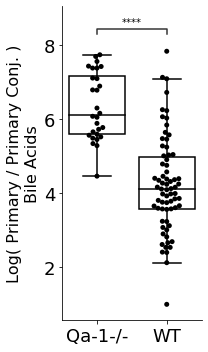

In [12]:
plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()
plot_dat["strain_genotype"] = pd.Categorical(plot_dat.strain_genotype, categories=["Qa-1-/-","WT"], ordered=True)
fig,ax =  plt.subplots(1,1, figsize=(3,5))

log_df = plot_dat.query('type_of_bile_acid in ["primary","primary conjugated"]').groupby(["sample","type_of_bile_acid"]).agg({"value":sum, "strain_genotype":"first"}).pivot_table(index="sample",columns="type_of_bile_acid", values="value").merge(md.loc[:,["strain_genotype"]], right_index=True, left_index=True)
log_df = log_df.query('primary != 0 & `primary conjugated` !=0')
log_df["LR"] = log_df.apply(axis=1, func = lambda x: log(x.primary/x["primary conjugated"]))

oo = ["Qa-1-/-","WT"]

sns.boxplot(data=log_df, x="strain_genotype", y="LR",
                ax=ax, color="white", order=oo,fliersize=0)
sns.swarmplot( data=log_df, x="strain_genotype", y="LR", color="black", ax=ax, order=oo)

for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
    
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
 
add_stat_annotation(ax, data=log_df, x="strain_genotype", y="LR",
                    box_pairs=[("Qa-1-/-", "WT")],
                    test='Mann-Whitney', text_format='star', loc='inside', order=oo)

ax.set_xlabel('')
ax.set_ylabel('Log( Primary / Primary Conj. )\nBile Acids', fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

plt.tight_layout()
fig.savefig("bile_acid_ratio.pdf")

In [221]:
log_df

,primary,primary conjugated,strain_genotype,LR
10781.Cage1.female.WT1,18893.173759,451.166185,WT,-3.734720
10781.Cage1.female.WT2,43249.325437,291.447488,WT,-4.999877
10781.Cage1.female.WT3,60033.004931,175.651520,WT,-5.834148
10781.Cage1.female.WT4,65596.602814,828.133089,WT,-4.372105
10781.Cage1.female.WT5,26090.999200,169.644939,WT,-5.035638
...,...,...,...,...
10781.Cage61.male.WT34,28855.976045,2627.165061,WT,-2.396412
10781.Cage61.male.WT35,35969.283035,4360.838631,WT,-2.110001
10781.Cage9.female.Qa2,72828.911553,272.860360,Qa-1-/-,-5.586908
10781.Cage9.female.Qa3,128829.344358,305.487029,Qa-1-/-,-6.044337


In [179]:
?pd.pivot_table

In [138]:
?add_stat_annotation

# Ggplot

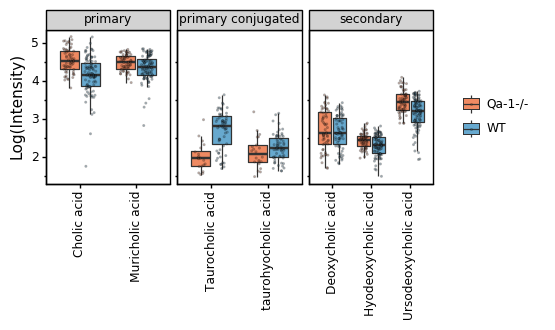

<ggplot: (326631467)>

In [13]:
pn.options.figure_size = (5,2)

plot_dat = df_collapse_melt.query('sample_type=="feces" & strain_genotype in ["WT","Qa-1-/-"]').copy()
plot_dat["log_value"] = [log(x+1,10) for x in plot_dat.value]
plot_dat = plot_dat.query('value > 0')

p = (pn.ggplot(data = plot_dat) +
     pn.geom_boxplot( pn.aes( x="bile_acid", y="log_value", fill="strain_genotype"), outlier_alpha=0) +
     pn.geom_point( pn.aes( x="bile_acid", y="log_value", group="strain_genotype", fill="strain_genotype"), size=.2, alpha=.3, position=pn.position_jitterdodge(jitter_width=.2)) +
     pn.facet_grid(".~type_of_bile_acid", space="free", scales="free") +
     pn.scale_fill_manual(values=["#ef8a62","#67a9cf"]) +
     pn.labs(x='',y='Log(Intensity)', fill='') +
     pn.theme_classic() +
     pn.theme(
         text= pn.element_text(color="black"),
         axis_text_x = pn.element_text(angle=90),
         panel_background = pn.element_rect(color="black", size=1),
          strip_background = pn.element_rect(fill="lightgrey")
     )
    )
p


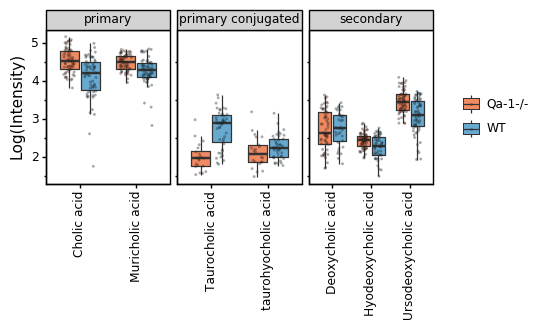

<ggplot: (-9223372036523030254)>

In [14]:
pn.options.figure_size = (5,2)

plot_dat = df_collapse_melt.query('sample_type=="feces" & description in ["WT","Qa-1-/-"]').copy()
plot_dat["log_value"] = [log(x+1,10) for x in plot_dat.value]
plot_dat = plot_dat.query('value > 0')

p = (pn.ggplot(data = plot_dat) +
     pn.geom_boxplot( pn.aes( x="bile_acid", y="log_value", fill="strain_genotype"), outlier_alpha=0) +
     pn.geom_point( pn.aes( x="bile_acid", y="log_value", group="strain_genotype", fill="strain_genotype"), size=.2, alpha=.3, position=pn.position_jitterdodge(jitter_width=.2)) +
     pn.facet_grid(".~type_of_bile_acid", space="free", scales="free") +
     pn.scale_fill_manual(values=["#ef8a62","#67a9cf"]) +
     pn.labs(x='',y='Log(Intensity)', fill='') +
     pn.theme_classic() +
     pn.theme(
         text= pn.element_text(color="black"),
         axis_text_x = pn.element_text(angle=90),
         panel_background = pn.element_rect(color="black", size=1),
          strip_background = pn.element_rect(fill="lightgrey")
     )
    )
p


# Log ratios

In [21]:
from qiime2.plugins import qurro
from qiime2.plugins import songbird

/anaconda3/envs/qiime2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/qiime2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/qiime2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/qiime2/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [23]:
id_to_keep = set(md.query('description in ["WT", "Qa-1-/-"]').sample_name)
bt_subset = bt.filter(ids_to_keep=id_to_keep, inplace=False)

In [261]:
?songbird.actions.multinomial

In [234]:
?qurro.actions.differential_plot

### Run songbird

In [24]:
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt_subset)
q2_md = q2.Metadata(md.apply(axis=0, func=lambda x: [str(y) for y in x]).set_index("sample_name"))
diffs, reg_stat, reg_bplt = songbird.actions.multinomial(table=qza,
                            metadata=q2_md,
                            formula="description",
                            min_sample_count=0,
                            min_feature_count=0
                            )


Instructions for updating:
Use `tf.random.categorical` instead.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.




/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4049: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for r in self.matrix_data.tocsr()]
/anaconda3/envs/qiime2/lib/python3.6/site-packages/biom/table.py:4052: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






  0%|          | 0/23000 [00:00<?, ?it/s]

100%|██████████| 23000/23000 [00:16<00:00, 1398.44it/s]


In [25]:
#Format feature metadta
ddd = {"Cholic acid":"a", "Muricholic acid":"b",
      "Ursodeoxycholic acid":"c",
      "Taurocholic acid":"d",
      "taurohyocholic acid":"e",
      "Deoxycholic acid":"f",
      "Hyodeoxycholic acid":"g"}
bile_acid_md["unique_name"] = [ddd[x] for x in bile_acid_md.bile_acid]

### Run qurro

In [26]:
bile_acid_md["type_of_bile_acid"] = ["prim conjugated" if x=="primary conjugated" else x for x in bile_acid_md["type_of_bile_acid"]]
bile_q2_md = q2.Metadata(bile_acid_md)
q_plt = qurro.actions.differential_plot(ranks = diffs,
                                       table=qza,
                                       sample_metadata=q2_md,
                                       feature_metadata=bile_q2_md)

/anaconda3/envs/qiime2/lib/python3.6/site-packages/qurro/_df_utils.py:126: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  table_sdf = pd.SparseDataFrame(table.matrix_data, default_fill_value=0.0)


164 sample(s) in the sample metadata file were not present in the BIOM table.
These sample(s) have been removed from the visualization.
Removed 1 empty sample(s).


In [27]:
q_plt.visualization

<visualization: Visualization uuid: 217cd814-4456-4948-8d39-10bb4b969b91>

## Run stats on qurro output

In [63]:
from scipy.stats import mannwhitneyu as mwu

In [271]:
?mwu

In [267]:
ls qurro_export

prim_vs_prim_conj.tsv     secondary_vs_primary.tsv


In [64]:
aa = pd.read_csv("qurro_export/prim_vs_prim_conj.tsv", sep='\t')
bb = pd.read_csv("qurro_export/secondary_vs_primary.tsv", sep='\t')

In [65]:
aa_wt = aa.query('strain_genotype=="WT"').Current_Natural_Log_Ratio
aa_wt = aa_wt[aa_wt.notna()]
aa_qa = aa.query('strain_genotype=="Qa-1-/-"').Current_Natural_Log_Ratio
aa_qa = aa_qa[aa_qa.notna()]

mwu(aa_wt,aa_qa)

MannwhitneyuResult(statistic=182.0, pvalue=1.7872258956646786e-10)

In [66]:
bb_wt = bb.query('strain_genotype=="WT"').Current_Natural_Log_Ratio
bb_wt = bb_wt[bb_wt.notna()]
bb_qa = bb.query('strain_genotype=="Qa-1-/-"').Current_Natural_Log_Ratio
bb_qa = bb_qa[bb_qa.notna()]

mwu(bb_wt,bb_qa)

MannwhitneyuResult(statistic=2614.0, pvalue=0.03699416834471452)

# Analyze presence/absense

In [72]:
md

,cage_id,collection_device,collection_method,collection_timestamp,description,diet,dna_extracted,elevation,elevation_units,empo_1,...,strain_genotype,strain_vendor,sulfatide,taxon_id,tazarotene_dose,tazarotene_treated,time_point,title,treatment,tube_id
sample_name,,,,,,,,,,,,,,,,,,,,,
10781.BLANK1.2A,not applicable,not applicable,not applicable,2016-12-09 0:00,not applicable,not applicable,True,193,meters,Control,...,not applicable,In-house,not applicable,256318,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,BLANK1.2A
10781.BLANK1.2B,not applicable,not applicable,not applicable,2016-12-09 0:00,not applicable,not applicable,True,193,meters,Control,...,not applicable,In-house,not applicable,256318,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,BLANK1.2B
10781.BLANK1.2C,not applicable,not applicable,not applicable,2016-12-09 0:00,not applicable,not applicable,True,193,meters,Control,...,not applicable,In-house,not applicable,256318,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,BLANK1.2C
10781.BLANK1.2D,not applicable,not applicable,not applicable,2016-12-09 0:00,not applicable,not applicable,True,193,meters,Control,...,not applicable,In-house,not applicable,256318,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,BLANK1.2D
10781.BLANK1.2E,not applicable,not applicable,not applicable,2016-12-09 0:00,not applicable,not applicable,True,193,meters,Control,...,not applicable,In-house,not applicable,256318,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,BLANK1.2E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10781.Water.2,not applicable,not applicable,not applicable,2016-03-03 0:00,not applicable,not applicable,True,193,meters,Free-living,...,not applicable,In-house,not applicable,1591089,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,San Diego City water as a source and filtered ...
10781.bedding.1,not applicable,not applicable,not applicable,2016-03-03 0:00,not applicable,not applicable,True,193,meters,Free-living,...,not applicable,In-house,not applicable,1591089,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,sample of rodent bedding (Envigo 7090 Teklad s...
10781.bedding.2,not applicable,not applicable,not applicable,2016-03-03 0:00,not applicable,not applicable,True,193,meters,Free-living,...,not applicable,In-house,not applicable,1591089,not applicable,not applicable,not applicable,NKT cell- NASH murine model - Microbiome: study 1,not applicable,sample of rodent bedding (Envigo 7090 Teklad s...


In [69]:
df_melt

,bile_acid,variable,value
0,Cholic acid,10781.Blank.No.Inj.10173,0.0
1,Deoxycholic acid,10781.Blank.No.Inj.10173,0.0
2,Hyodeoxycholic acid,10781.Blank.No.Inj.10173,0.0
3,Muricholic acid,10781.Blank.No.Inj.10173,0.0
4,Taurocholic acid,10781.Blank.No.Inj.10173,0.0
...,...,...,...
1913,Hyodeoxycholic acid,10781.Other.04,0.0
1914,Muricholic acid,10781.Other.04,0.0
1915,Taurocholic acid,10781.Other.04,0.0
1916,Ursodeoxycholic acid,10781.Other.04,0.0


In [76]:
df = pd.DataFrame(bt.to_dataframe())
#Add bile acid id to dataframe
df = df.merge(bile_acid_md.loc[:,["bile_acid"]], left_index=True, right_index=True)
#Group by bile acid and get max of each
df = df.groupby("bile_acid").agg("max")
df["bile_acid"] = df.index
df_melt = df.melt(id_vars="bile_acid")
#Add in sample metadata
df_melt = df_melt.merge(md.loc[:,["description"]].reset_index(), left_on="variable", right_on="sample_name")
#Get total sample n
wt_tot_n = len(set(df_melt.loc[ df_melt.description=="WT"].sample_name))
qa1_tot_n = len(set(df_melt.loc[ df_melt.description=="Qa-1-/-"].sample_name))
#Subset only WT and Qa1
df_melt = df_melt.loc[ [x in ['Qa-1-/-', "WT"] for x in df_melt.description]]
wt_tot = len(set(df_melt))
df_melt = df_melt.loc[ df_melt.value !=0]

In [77]:
count_df = pd.DataFrame()

mets = set(df_melt.bile_acid)
for met in mets:
    wt_n = df_melt.query('description=="WT" and bile_acid== @met').shape[0]
    qa1_n = df_melt.query('description=="Qa-1-/-" and bile_acid== @met').shape[0]
    count_df = count_df.append({"bile_acid":met, "wt_n":wt_n, "qa1_n":qa1_n}, ignore_index=True)


count_df["wt_pct"] = [x/wt_tot_n for x in count_df.wt_n]
count_df["qa1_pct"] = [x/qa1_tot_n for x in count_df.qa1_n]
count_df["pct_dif"] = count_df.apply(axis=1, func=lambda x: abs(x.wt_pct - x.qa1_pct))
count_df = count_df.merge(bile_acid_md.loc[:,["type_of_bile_acid", "bile_acid"]], on="bile_acid")
count_df.sort_values("pct_dif").head()

,bile_acid,qa1_n,wt_n,wt_pct,qa1_pct,pct_dif,type_of_bile_acid
23,Cholic acid,64.0,59.0,0.983333,1.0,0.016667,primary
21,Cholic acid,64.0,59.0,0.983333,1.0,0.016667,primary
22,Cholic acid,64.0,59.0,0.983333,1.0,0.016667,primary
39,Cholic acid,64.0,59.0,0.983333,1.0,0.016667,primary
24,Cholic acid,64.0,59.0,0.983333,1.0,0.016667,primary


In [78]:
print(wt_tot_n)
print(qa1_tot_n)

60
64


### Plot

In [54]:
import plotnine as pn
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
count_df_melt = count_df.loc[:,["bile_acid","wt_pct","qa1_pct","type_of_bile_acid"]].melt(id_vars=["bile_acid", "type_of_bile_acid"])
count_df_melt.head()

,bile_acid,type_of_bile_acid,variable,value
0,Deoxycholic acid,secondary,wt_pct,0.550000
1,Muricholic acid,primary,wt_pct,0.983333
2,Muricholic acid,primary,wt_pct,0.983333
3,Muricholic acid,primary,wt_pct,0.983333
4,Muricholic acid,primary,wt_pct,0.983333


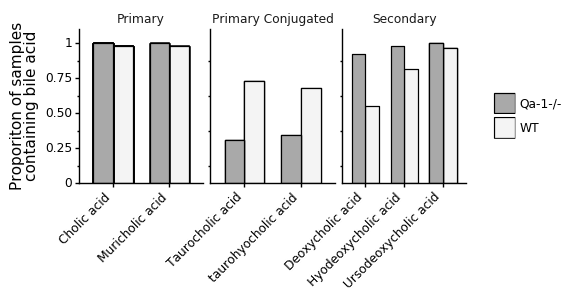

<ggplot: (-9223372036513835106)>

In [101]:
pn.options.figure_size = (5,2)

count_df_melt = count_df_melt.replace({"primary":"Primary","primary conjugated":"Primary Conjugated",
                                       "secondary":"Secondary","qa1_pct":"Qa-1-/-","wt_pct":"WT"})

a=(pn.ggplot(data= count_df_melt) +
pn.geom_bar( pn.aes(x="bile_acid", y="value", group="variable", fill="variable"), 
            color="black", stat="identity", position="dodge", width=.7) +
   pn.scale_y_continuous(expand=[0,0], limits=[0,1.1]) +
 pn.facet_grid(".~type_of_bile_acid", scales="free") +
   pn.scale_fill_manual(values=["darkgrey","#F4F4F4"]) +
 pn.labs(x="",y="Proporiton of samples\ncontaining bile acid", fill='') +
   pn.theme_classic() +
 pn.theme(axis_text_x=pn.element_text(angle=45, hjust=1),
         legend_title=pn.element_text(size=10),
         axis_text = pn.element_text(color="black"),
         panel_background=pn.element_blank(),
        axis_line = pn.element_line(),
         panel_border = pn.element_rect(fill=None),
          strip_background = pn.element_blank()
         )
)
a